# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [ ]:
%pip install palmerpenguins

In [ ]:
# Code Here
%echo
import numpy as np
import pandas as pd
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [3]:
penguins = load_penguins()

In [4]:
penguins.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11
year,0


In [5]:
penguins.dropna(inplace=True)

In [6]:
penguins.isnull().sum()

,0
species,0
island,0
bill_length_mm,0
bill_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0
year,0


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [7]:
y = penguins["species"]

X = pd.get_dummies(
    penguins.drop(columns=["species"]),
    drop_first=True
)

In [8]:
# Code Here
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [9]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc  = scaler.transform(X_test)

In [10]:
param_grid = {"n_neighbors": list(range(1, 26))}
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, scoring="accuracy", cv=5)
grid.fit(X_train_sc, y_train)

grid.best_params_["n_neighbors"]

11

In [11]:

grid.best_score_

np.float64(0.992)

In [12]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results["K"] = cv_results["param_n_neighbors"]
cv_results["Accuracy"] = cv_results["mean_test_score"]

best_k = int(grid.best_params_["n_neighbors"])
second_best_k = int(cv_results.sort_values("Accuracy", ascending=False)["K"].iloc[1])
print( best_k, "and", second_best_k)

11 and 12


In [13]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
knn2 = KNeighborsClassifier(n_neighbors=second_best_k)

knn1.fit(X_train_sc, y_train)
knn2.fit(X_train_sc, y_train)

KNeighborsClassifier(n_neighbors=12)

In [14]:
dt3 = DecisionTreeClassifier(max_depth=3, random_state=0)
dt5 = DecisionTreeClassifier(max_depth=5, random_state=0)

dt3.fit(X_train, y_train)
dt5.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=0)

In [15]:
tree = DecisionTreeClassifier(random_state=0)

dt_param_grid = {"max_depth": list(range(1, 11))}

grid_tree = GridSearchCV(
    tree, dt_param_grid,
    scoring="accuracy", cv=5
)
grid_tree.fit(X_train, y_train)

grid_tree.best_params_["max_depth"]

5

In [16]:
cv_results = pd.DataFrame(grid_tree.cv_results_)
cv_results["Depth"] = cv_results["param_max_depth"]
cv_results["Accuracy"] = cv_results["mean_test_score"]

depth1 = int(grid_tree.best_params_["max_depth"])
depth2 = int(cv_results.sort_values("Accuracy", ascending=False)["Depth"].iloc[1])

print(depth1," ", depth2)

5   6


In [17]:
dt1 = DecisionTreeClassifier(max_depth=depth1, random_state=0)
dt2 = DecisionTreeClassifier(max_depth=depth2, random_state=0)

dt1.fit(X_train, y_train)
dt2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

In [18]:
def evaluate_classifier(name, model, Xtr, Xte, ytr, yte):
    y_pred = model.predict(Xte)
    cm = confusion_matrix(yte, y_pred, labels=model.classes_)
    acc = accuracy_score(yte, y_pred)
    print(name)
    print("Confusion matrix (rows=actual, cols=pred):\n",
          pd.DataFrame(cm, index=model.classes_, columns=model.classes_))
    print(f"\nOverall Accuracy: {acc:.4f}")
    print("\nPrecision, Recall, F1 by class:")
    print(pd.DataFrame(classification_report(yte, y_pred, output_dict=True)).transpose())

    # AUC (one-vs-rest)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(Xte)
        classes = model.classes_
        y_bin = label_binarize(yte, classes=classes)
        aucs = {cls: roc_auc_score(y_bin[:, i], y_proba[:, i]) for i, cls in enumerate(classes)}
        print("\nAUC by class:", {k: round(v,4) for k,v in aucs.items()})
    else:
        print("\nModel has no predict_proba; skipping AUC.")

# Evaluate all four
evaluate_classifier(f"kNN (K={best_k})", knn1, X_train_sc, X_test_sc, y_train, y_test)
evaluate_classifier(f"kNN (K={second_best_k})", knn2, X_train_sc, X_test_sc, y_train, y_test)
evaluate_classifier("Decision Tree (depth=5)", dt1, X_train, X_test, y_train, y_test)
evaluate_classifier("Decision Tree (depth=6)", dt2, X_train, X_test, y_train, y_test)


kNN (K=11)
Confusion matrix (rows=actual, cols=pred):
            Adelie  Chinstrap  Gentoo
Adelie         36          1       0
Chinstrap       0         17       0
Gentoo          0          0      30

Overall Accuracy: 0.9881

Precision, Recall, F1 by class:
              precision    recall  f1-score    support
Adelie         1.000000  0.972973  0.986301  37.000000
Chinstrap      0.944444  1.000000  0.971429  17.000000
Gentoo         1.000000  1.000000  1.000000  30.000000
accuracy       0.988095  0.988095  0.988095   0.988095
macro avg      0.981481  0.990991  0.985910  84.000000
weighted avg   0.988757  0.988095  0.988184  84.000000

AUC by class: {'Adelie': np.float64(1.0), 'Chinstrap': np.float64(1.0), 'Gentoo': np.float64(1.0)}
kNN (K=12)
Confusion matrix (rows=actual, cols=pred):
            Adelie  Chinstrap  Gentoo
Adelie         37          0       0
Chinstrap       0         17       0
Gentoo          0          0      30

Overall Accuracy: 1.0000

Precision, Recall, F1 b

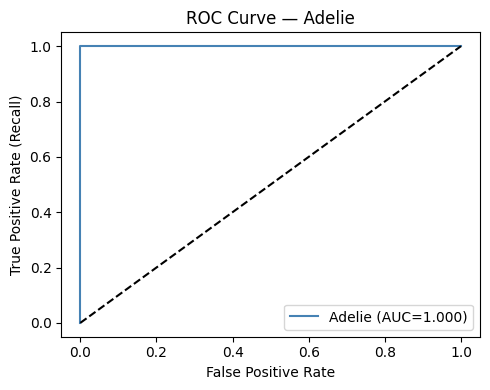

In [25]:
species_of_interest = "Adelie"
roc_model = knn1

proba = roc_model.predict_proba(X_test_sc)
classes = roc_model.classes_
y_bin = label_binarize(y_test, classes=classes)
i = list(classes).index(species_of_interest)

fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
auc_val = roc_auc_score(y_bin[:, i], proba[:, i])

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"{species_of_interest} (AUC={auc_val:.3f})", color="steelblue")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve — {species_of_interest}")
plt.legend()
plt.tight_layout()
plt.show()


The kNN classifier achieved 100% accuracy on the test data. While this could indicate overfitting in some problems, it is plausible here because the Palmer Penguins dataset has clear separation among species in features like bill length, flipper length, and body mass.
Cross-validation confirms that this performance is stable across folds, suggesting the model captures genuine structure rather than memorizing noise.

On that note, the ROC curve for the Adelie species yielded an AUC of 1.0, indicating perfect separability. This result is plausible because the Palmer Penguins dataset contains clearly distinct physical measurements among species. The model correctly classifies all Adelie individuals without false positives or negatives.